# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [266]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [267]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [268]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [269]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220121.csv


In [270]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [271]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [272]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    return table2

In [273]:
df = prepare_df(raw_df)
### ENQUANTO PODER DATA NAO ATUALIZA (SUA PRÓPRIA PESQUISA)
### DADOS RETIRADOS DAQUI: https://bit.ly/3Ax2c93
df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-20"],
                        "mes": ["2022_01"],
                        "LULA":[1260],
                        "NULO":[360],
                        "OUTROS":[1350],
                        "TOTAL": [3000],
                        "instituto":["PoderData"]}))
###
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [274]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

7.35

In [275]:
def run_prob_weekly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like * 0.5
        print(obj.data_pesquisa, posterior/posterior.sum(), simulate_prob(posterior))
        prior = 1000 * posterior/posterior.sum()

run_prob_weekly(simulate_prob_freq)

2021-11-04 [0.4321608 0.1758794 0.3919598] 97.84
2021-11-06 [0.45645129 0.15766153 0.38588718] 99.98
2021-11-19 [0.40245836 0.14577191 0.45176974] 0.89
2021-11-20 [0.38622918 0.10838595 0.50538487] 0.0
2021-11-24 [0.36256053 0.09871998 0.53871949] 0.0
2021-11-29 [0.40755336 0.05284674 0.5395999 ] 0.0
2021-12-05 [0.43401702 0.08673111 0.47925187] 1.72
2021-12-09 [0.41001064 0.10295694 0.48703242] 0.05
2021-12-11 [0.41900981 0.12799097 0.45299921] 5.609999999999999
2021-12-13 [0.39900491 0.10649549 0.49449961] 0.0
2021-12-13 [0.43952269 0.12325612 0.43722119] 55.05
2021-12-16 [0.46571221 0.10820901 0.42607878] 98.6
2021-12-16 [0.45562273 0.11176678 0.43261049] 82.95
2021-12-21 [0.42224909 0.11070671 0.46704419] 1.1400000000000001
2022-01-09 [0.44052984 0.11651854 0.44295161] 45.6
2022-01-12 [0.43743698 0.12021095 0.44235206] 41.75
2022-01-13 [0.42751046 0.1163334  0.45615613] 10.100000000000001
2022-01-20 [0.42555753 0.11924885 0.45519361] 5.96


In [276]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,3215.000,895.000,3325.000,7465.0


In [277]:
def run_prob_monthly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    df_by_mes = df.groupby("mes").sum().reset_index()
    for obj in df_by_mes.itertuples():
        # print(obj)
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like * 0.5
        print(obj.mes, posterior, simulate_prob(posterior))
        prior = 2000 * posterior/posterior.sum()
run_prob_monthly(simulate_prob_freq)

2021_11 [3444.424  883.666 4141.41 ] 0.0
2021_12 [4491.62927339 1195.48316943 4771.38755718] 0.26
2022_01 [2466.44330418  676.11465209 2574.94204373] 7.08


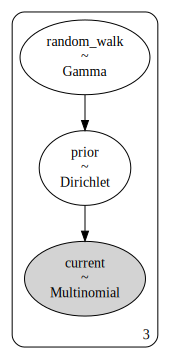

In [278]:
def build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0) -> pm.Model:
    observed = observed.astype("int32")
    with pm.Model() as dirichlet_model:
        rw = pm.Gamma("random_walk",
                      alpha=(rw_alpha_mult * prior),
                      beta=(rw_beta_mult * np.ones(3)), shape=(3,)
                      )
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=rw, shape=(3,),
        )

        pm.Multinomial(
            "current", n=observed.sum(), p=(previous_month_prior), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [279]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

### Weekly update

In [280]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

# df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df_results_weekly = pd.DataFrame({})
# print(df)

for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model_w = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    trace_w, ppc_w = sampling(model_w)
    posterior_w = ppc_w['current']
    # print(f">>> posterior.shape={posterior.shape}")
    prior = dirichlet.mle(posterior_w/posterior_w.sum(axis=1).reshape(-1, 1))
    # print('dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))=,', prior)
    qs = calc_prob_lula_win(model, trace_w, ppc=ppc_w)
    # print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={qs}% <<<")
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior_w/posterior_w.sum(axis=1).reshape(-1, 1)
    df_results_weekly = df_results_weekly.append(pd.DataFrame({"data":[obj.data_pesquisa],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_weekly

>>> observed = [880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[621.44848525 240.55179342 637.19826208],  qs=[37.6475 40.62   41.3125]% <<<
lula= [0.38989899 0.41414141 0.43939394]
nulo= [0.14242424 0.16010101 0.17929293]
demais= [0.39949495 0.42525253 0.45001263]
>>> observed = [990.24 288.82 783.94]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-06, updaed_prior=[700.75179348 251.90164199 671.23193411],  qs=[41.965 42.94  52.78 ]% <<<
lula= [0.40756914 0.43134401 0.45608928]
nulo= [0.13779719 0.15526443 0.17273168]
demais= [0.38913149 0.41339156 0.43668122]
>>> observed = [ 704.98  270.68 1044.34]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-19, updaed_prior=[668.55714144 243.67956019 710.8893419 ],  qs=[32.2075 39.64   40.355 ]% <<<
lula= [0.38850347 0.41179386 0.43608771]
nulo= [0.13280476 0.15014866 0.16749257]
demais= [0.41377602 0.43805748 0.46134787]
>>> observed = [ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-20, updaed_prior=[655.30442388 214.00658088 761.20592271],  qs=[27.7625 37.76   38.6475]% <<<
lula= [0.3785 0.402  0.426 ]
nulo= [0.115 0.131 0.148]
demais= [0.443 0.467 0.49 ]
>>> observed = [ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-24, updaed_prior=[745.92880312 233.03302843 955.6170513 ],  qs=[25.515 34.82  35.7  ]% <<<
lula= [0.3640404  0.38545455 0.40767677]
nulo= [0.10626263 0.12040404 0.13494949]
demais= [0.47232323 0.49414141 0.5159596 ]
>>> observed = [1883.628  140.832 2376.54 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-29, updaed_prior=[1249.2169797   272.72001044 1590.88509524],  qs=[26.565 36.28  37.03 ]% <<<
lula= [0.3839509  0.40122755 0.41827688]
nulo= [0.07774494 0.08751989 0.09774949]
demais= [0.49329393 0.51102523 0.52875654]
>>> observed = [937.02 244.44 855.54]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-05, updaed_prior=[743.81575803 167.63746899 904.30535199],  qs=[27.6   37.5   38.125]% <<<
lula= [0.3870334  0.40962672 0.43222004]
nulo= [0.07907662 0.09233792 0.10559921]
demais= [0.47495088 0.4975442  0.521611  ]
>>> observed = [444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-09, updaed_prior=[422.31092932 102.1223956  521.47654703],  qs=[27.19 37.02 37.89]% <<<
lula= [0.375      0.40333333 0.43416667]
nulo= [0.08       0.0975     0.11583333]
demais= [0.46916667 0.49833333 0.5275    ]
>>> observed = [856.856 306.306 838.838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-11, updaed_prior=[600.02669376 167.92216249 689.62758995],  qs=[28.4125 38.66   39.4   ]% <<<
lula= [0.387  0.4115 0.4365]
nulo= [0.099 0.115 0.132]
demais= [0.448  0.473  0.4995]
>>> observed = [ 758.  170. 1072.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[639.3729597  170.06694629 775.04772667],  qs=[27.025  37.02   38.1325]% <<<
lula= [0.3795 0.4035 0.4285]
nulo= [0.093     0.107     0.1230125]
demais= [0.4645 0.489  0.513 ]
>>> observed = [960.96 280.28 760.76]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[667.3715635  182.23642145 732.67138404],  qs=[30.3975 40.17   40.895 ]% <<<
lula= [0.398  0.4215 0.446 ]
nulo= [0.0995 0.115  0.1315]
demais= [0.438 0.463 0.487]
>>> observed = [1759.68  366.6  1539.72]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[1187.12217402  293.5495062  1198.43407315],  qs=[41.915 43.16  44.005]% <<<
lula= [0.42385371 0.44323144 0.46206332]
nulo= [0.09798035 0.10944323 0.12145197]
demais= [0.42903248 0.44732533 0.46588428]
>>> observed = [440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[399.74715597  99.69661151 403.53060947],  qs=[41.955 43.01  44.12 ]% <<<
lula= [0.41188119 0.44257426 0.47524752]
nulo= [0.09009901 0.10990099 0.13168317]
demais= [0.41386139 0.44752475 0.47920792]
>>> observed = [1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-21, updaed_prior=[862.06426218 224.16090887 948.89661698],  qs=[29.9575 40.15   41.175 ]% <<<
lula= [0.40233333 0.42366667 0.44533333]
nulo= [0.097325   0.11       0.12433333]
demais= [0.445      0.46633333 0.488     ]
>>> observed = [900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-09, updaed_prior=[696.129243   181.96805499 738.21575126],  qs=[33.5575 41.17   42.1775]% <<<
lula= [0.40663265 0.43061224 0.45459184]
nulo= [0.09744898 0.1127551  0.12806122]
demais= [0.43265306 0.45663265 0.48163265]
>>> observed = [440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-12, updaed_prior=[383.85000231 102.05922486 405.16314047],  qs=[35.7775 41.19   42.3175]% <<<
lula= [0.39705882 0.43137255 0.46372549]
nulo= [0.09411765 0.11470588 0.13529412]
demais= [0.42254902 0.45490196 0.48921569]
>>> observed = [615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-13, updaed_prior=[487.69366192 129.67760665 527.54937849],  qs=[32.1175 40.39   41.475 ]% <<<
lula= [0.396633   0.42558923 0.45387205]
nulo= [0.0956229  0.11313131 0.13198653]
demais= [0.43232323 0.46060606 0.49023569]
>>> observed = [1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-20, updaed_prior=[907.10467679 248.31411395 976.67274337],  qs=[30.9325 40.67   41.5275]% <<<
lula= [0.4047138  0.42525253 0.44713805]
nulo= [0.1030303  0.11649832 0.12996633]
demais= [0.43703704 0.45824916 0.47845118]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.414141,0.439394,0.399495,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.456089,0.389131,0.413392,0.436681
0,2021-11-19,0.388503,0.411794,0.436088,0.413776,0.438057,0.461348
0,2021-11-20,0.378500,0.402000,0.426000,0.443000,0.467000,0.490000
0,2021-11-24,0.364040,0.385455,0.407677,0.472323,0.494141,0.515960
0,2021-11-29,0.383951,0.401228,0.418277,0.493294,0.511025,0.528757
0,2021-12-05,0.387033,0.409627,0.432220,0.474951,0.497544,0.521611
0,2021-12-09,0.375000,0.403333,0.434167,0.469167,0.498333,0.527500
0,2021-12-11,0.387000,0.411500,0.436500,0.448000,0.473000,0.499500
0,2021-12-13,0.379500,0.403500,0.428500,0.464500,0.489000,0.513000


model = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)

>>> data_pesquisa=2022-01-13, updaed_prior=[483.38778278 128.66210683 523.97315797],  qs=[ 9.25   9.69  10.065]% <<<
lula= [0.396633   0.42558923 0.45454545]
nulo= [0.0956229  0.11313131 0.13265993]
demais= [0.43164983 0.46127946 0.49158249]

>>> data_pesquisa=2022-01-20, updaed_prior=[896.11772754 245.53127403 967.04329633],  qs=[4.64 4.95 5.32]% <<<
lula= [0.4037037  0.42491582 0.44612795]
nulo= [0.1030303  0.11649832 0.13030303]
demais= [0.43737374 0.45858586 0.47979798]

In [281]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [282]:
az.summary(trace_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],4871.338,80.088,4715.569,5013.745,1.344,0.950,3548.0,2547.0,1.0
random_walk[1],1318.709,40.342,1246.336,1398.070,0.769,0.546,2765.0,2918.0,1.0
random_walk[2],5258.339,83.780,5102.614,5414.195,1.430,1.011,3421.0,1968.0,1.0
prior[0],0.425,0.006,0.414,0.435,0.000,0.000,2463.0,2576.0,1.0
prior[1],0.116,0.004,0.109,0.123,0.000,0.000,2188.0,2323.0,1.0
prior[2],0.458,0.006,0.448,0.469,0.000,0.000,2964.0,2676.0,1.0


In [283]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula_w = ppc_w['current'][:,0] / ppc_w['current'].sum(axis=1) * 100
nulo_w = ppc_w['current'][:,1] / ppc_w['current'].sum(axis=1) * 100.00
demais_w = ppc_w['current'][:,2] / ppc_w['current'].sum(axis=1) * 100
# az.plot_posterior({'Lula': lula, 'Demais': demais});
# az.plot_posterior({}, ax=ax[1])

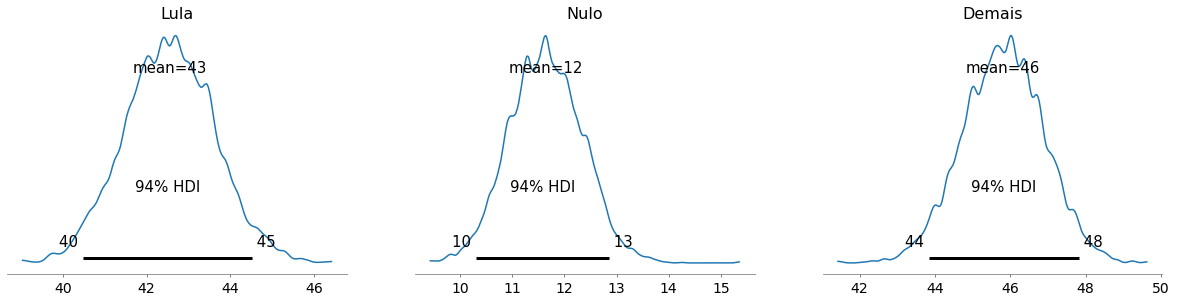

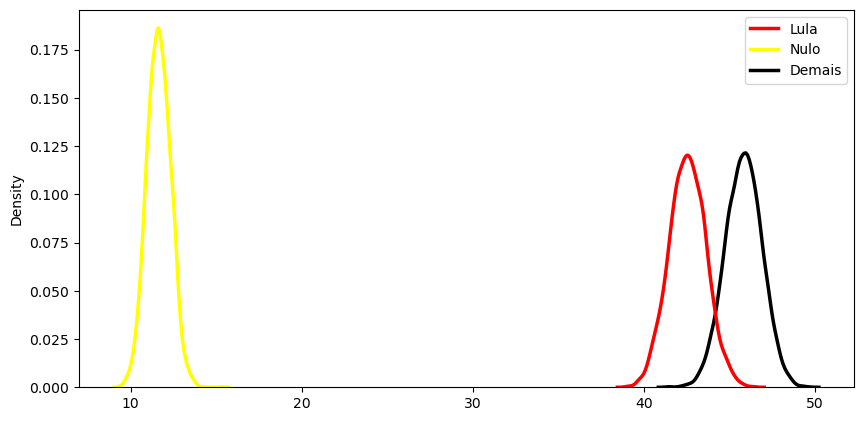

In [284]:
# a0 = np.array([100, 299, 100])
# D0 = np.random.dirichlet(a0, 1000)
# D0
post_pred_w = pd.DataFrame({'Lula': lula_w, 'Nulo': nulo_w, 'Demais': demais_w})
az.plot_posterior(post_pred_w.to_dict(orient='list'));
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)

sns.kdeplot(data=post_pred_w, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=100);

In [285]:
df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.414141,0.439394,0.399495,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.456089,0.389131,0.413392,0.436681
0,2021-11-19,0.388503,0.411794,0.436088,0.413776,0.438057,0.461348
0,2021-11-20,0.378500,0.402000,0.426000,0.443000,0.467000,0.490000
0,2021-11-24,0.364040,0.385455,0.407677,0.472323,0.494141,0.515960
0,2021-11-29,0.383951,0.401228,0.418277,0.493294,0.511025,0.528757
0,2021-12-05,0.387033,0.409627,0.432220,0.474951,0.497544,0.521611
0,2021-12-09,0.375000,0.403333,0.434167,0.469167,0.498333,0.527500
0,2021-12-11,0.387000,0.411500,0.436500,0.448000,0.473000,0.499500
0,2021-12-13,0.379500,0.403500,0.428500,0.464500,0.489000,0.513000


## MONTHLY

In [286]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model, trace, 50, ppc=ppc)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048.848 1507.332 7382.82 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


NameError: name 'ppc' is not defined

model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [ ]:
az.summary(trace_m)

In [ ]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=500);

In [ ]:
(post_pred.Lula > post_pred.Demais).mean()

## Playground

In [ ]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

In [ ]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [ ]:
observed.sum(axis=1)

In [ ]:
current_observed.sum(axis=0)

In [ ]:
current_observed.sum(axis=1)

In [ ]:
current_observed

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [ ]:
# hide_input
# This cell is required for the export to HTML to work.


In [ ]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

In [ ]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


In [ ]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [ ]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

In [ ]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

In [ ]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [ ]:
dir2

In [ ]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

In [ ]:
np.arange(10)

In [ ]:
np.linspace(0,1, 101)

In [ ]:
x = np.arange(5,10)

In [ ]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

In [ ]:
1.96 * np.sqrt((0.5**2)/3000)

In [ ]:
1./(1./0.01789 + 1./0.0200)

In [ ]:
1/100

In [ ]:
1/(1./0.01789 + 1./0.0200)

In [ ]:
X = np.arange(1, 100)
X.mean(), X.std()

(50.0, 28.577380332470412)

20.543583566122344 4.446651315132218


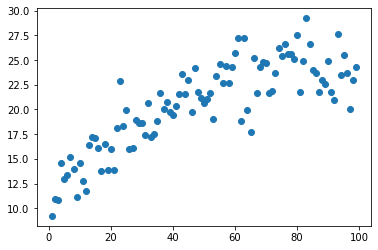

In [ ]:
Y = 12*(np.sin(X/50) + 1) + np.random.normal(0, 2, X.size)
print(Y.mean(), Y.std())
plt.scatter(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


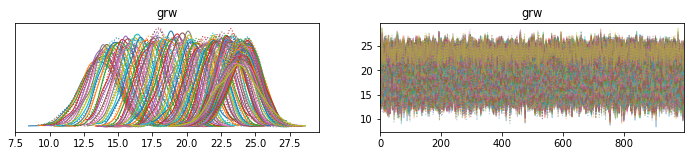

In [ ]:
with pm.Model() as grw:
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=0.5, shape=X.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=Y.std(), observed=Y)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [ ]:
trace.posterior.grw.mean(axis=0).mean(axis=0)

<xarray.DataArray 'grw' (grw_dim_0: 99)>
array([13.53145899, 13.57597971, 13.64814222, 13.79262452, 13.91232107,
       14.02703843, 14.16237848, 14.29720825, 14.43455276, 14.57649994,
       14.74431263, 14.92655845, 15.15098872, 15.36342954, 15.55679744,
       15.74343886, 15.92279749, 16.11261734, 16.31148026, 16.50715453,
       16.73292296, 16.98756432, 17.24979188, 17.4416245 , 17.61695405,
       17.76508783, 17.93304521, 18.11304747, 18.29325255, 18.47845587,
       18.64627917, 18.79771092, 18.97263332, 19.14908779, 19.35659571,
       19.56069719, 19.75353286, 19.93537284, 20.11564147, 20.3010874 ,
       20.50947978, 20.70054655, 20.88291747, 21.03368753, 21.18034152,
       21.29570353, 21.43784214, 21.52848192, 21.65513033, 21.75893768,
       21.86170413, 21.99117369, 22.13118834, 22.31231048, 22.45050863,
       22.57315166, 22.70499511, 22.79478137, 22.91935759, 23.00304035,
       23.06930532, 23.06331378, 23.10936743, 23.12793951, 23.17048524,
       23.2926946 , 23.38046774, 23.48860089, 23.5841288 , 23.67446622,
       23.73690048, 23.84474157, 23.99342042, 24.11843438, 24.21984432,
       24.3069952 , 24.34811943, 24.37884641, 24.37795848, 24.38919094,
       24.36203944, 24.37384165, 24.36139604, 24.30523337, 24.18095606,
       24.08613964, 24.0063687 , 23.93673087, 23.90036499, 23.86715065,
       23.84360755, 23.83465486, 23.8418785 , 23.81105366, 23.76764942,
       23.73137427, 23.69349614, 23.68481591, 23.69334685])
Coordinates:
  * grw_dim_0  (grw_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

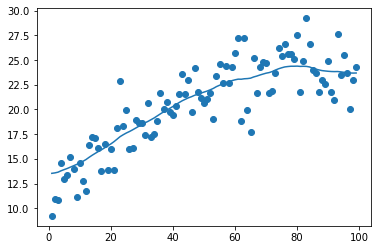

In [ ]:
plt.scatter(X, Y)
plt.plot(X, trace.posterior.grw.mean(axis=0).mean(axis=0))

In [ ]:
# az.summary(trace)
trace.posterior.grw.mean(axis=0).shape

(1000, 99)

In [ ]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)


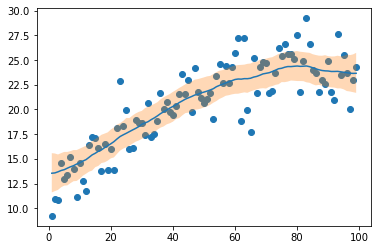

In [ ]:
plt.scatter(X, Y)
plt.plot(X, qs[1])
plt.fill_between(x=X,y1=qs[0], y2=qs[2], alpha=0.3)

In [ ]:
df.shape

(18, 7)

In [341]:
XL = np.arange(0,18)
YL = raw_df.query("partido == 'PT' ")["percentual"]
# XL = df_results_weekly.data
YL = YL.append(to_append=pd.Series([42]))
#YL[10:13]=np.nan

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.


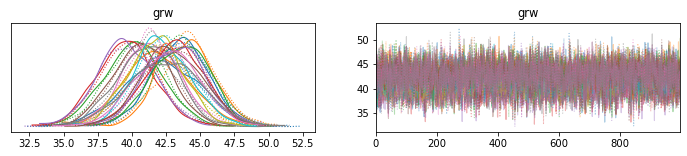

In [362]:
with pm.Model() as grw:
    
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=2.0, shape=XL.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=YL.std(), observed=YL)
    
    trace = pm.sample(1000, tune=500, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


18 18


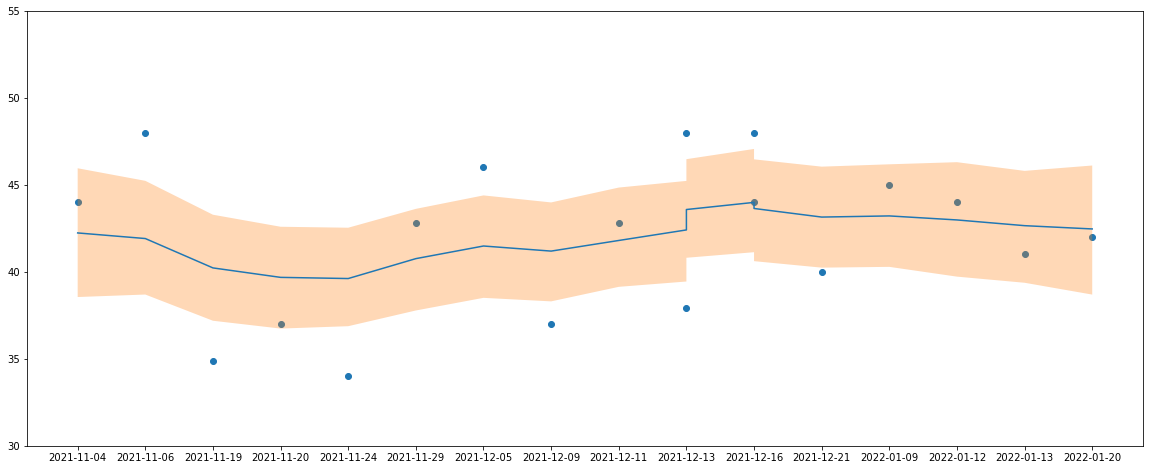

In [363]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
plt.figure(figsize=(20,8))
plt.ylim(30, 55)

print(df_results_weekly.data.size, YL.size)
plt.scatter(df_results_weekly.data, YL)
plt.plot(df_results_weekly.data, qs[1])
plt.fill_between(x=df_results_weekly.data,y1=qs[0], y2=qs[2], alpha=0.3)

In [364]:
df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.414141,0.439394,0.399495,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.456089,0.389131,0.413392,0.436681
0,2021-11-19,0.388503,0.411794,0.436088,0.413776,0.438057,0.461348
0,2021-11-20,0.378500,0.402000,0.426000,0.443000,0.467000,0.490000
0,2021-11-24,0.364040,0.385455,0.407677,0.472323,0.494141,0.515960
0,2021-11-29,0.383951,0.401228,0.418277,0.493294,0.511025,0.528757
0,2021-12-05,0.387033,0.409627,0.432220,0.474951,0.497544,0.521611
0,2021-12-09,0.375000,0.403333,0.434167,0.469167,0.498333,0.527500
0,2021-12-11,0.387000,0.411500,0.436500,0.448000,0.473000,0.499500
0,2021-12-13,0.379500,0.403500,0.428500,0.464500,0.489000,0.513000


In [388]:
# YL = YL/100.0
dfrw.data.values[-1]

'2022-01-20'

Text(2022-01-20, 0.45724915824915824, '45.82%')

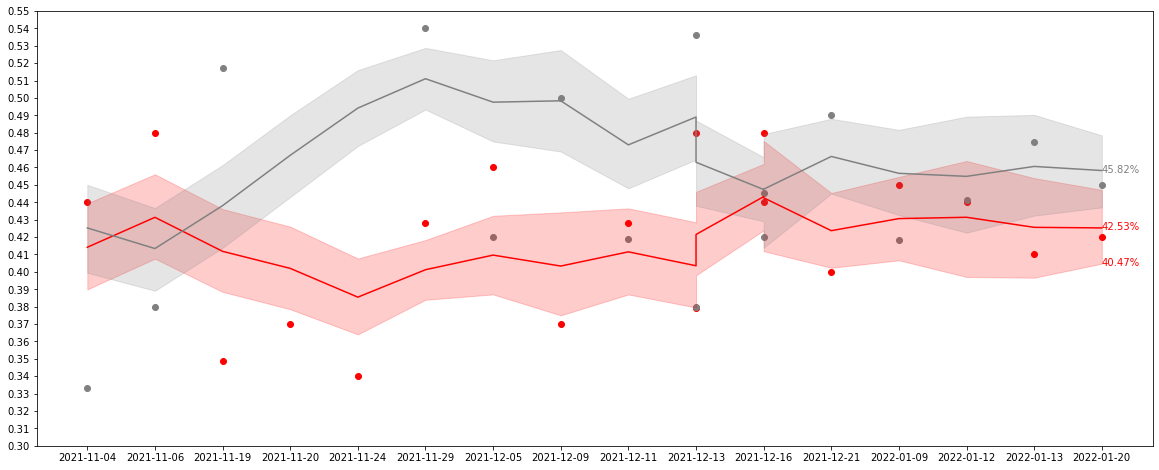

In [399]:
dfrw = df_results_weekly

plt.figure(figsize=(20,8))
plt.ylim(0.30, 0.55)
plt.yticks(np.arange(0.30, 0.55, 0.01))
plt.scatter(dfrw.data, YL/100.0, color='red')
plt.scatter(dfrw.data, df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red')
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray')
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')